In [ ]:
import numpy as np
import pandas as pd
import os
import glob
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from PIL import Image
import cv2

# Sklearn Utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Define dataset path
dataset_path = "/content/drive/MyDrive/Colab Notebooks/FacesProject/faces"
orl_dataset_path = "/content/drive/MyDrive/Colab Notebooks/FacesProject/ORL_faces.npz"
orl_data = np.load(orl_dataset_path)

# Initialize data and labels
data = []
labels = []

# Read images and labels
for subject_dir in os.listdir(dataset_path):
    subject_path = os.path.join(dataset_path, subject_dir)
    if os.path.isdir(subject_path):
        for image_file in os.listdir(subject_path):
            img_path = os.path.join(subject_path, image_file)

            # Load image and resize to (92x112)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (92, 112))
            data.append(image)
            labels.append(subject_dir)  # Label = folder name

# Convert to NumPy arrays
data = np.array(data)
labels = np.array(labels)

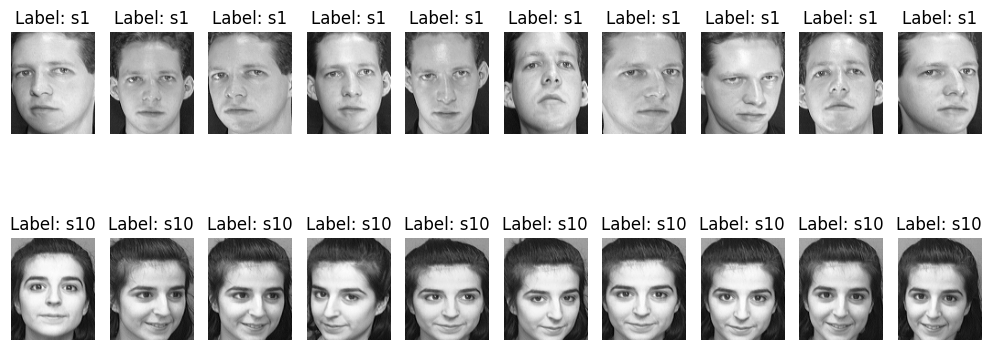

In [ ]:
# Plot a few sample images
def visualize_samples(data, labels, num_samples):
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        plt.subplot(2, num_samples // 2, i + 1)
        plt.imshow(data[i].reshape(112, 92), cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize first 10 images
visualize_samples(data, labels, num_samples=20)

In [ ]:
# Check the structure of the training and test data
trainX = orl_data['trainX']
trainY = orl_data['trainY']
testX = orl_data['testX']
testY = orl_data['testY']

# Display the shapes and data types of the datasets
data_info = {
    "trainX_shape": trainX.shape,
    "trainX_dtype": trainX.dtype,
    "trainY_shape": trainY.shape,
    "trainY_dtype": trainY.dtype,
    "testX_shape": testX.shape,
    "testX_dtype": testX.dtype,
    "testY_shape": testY.shape,
    "testY_dtype": testY.dtype,
}
data_info

{'trainX_shape': (240, 10304),
 'trainX_dtype': dtype('float64'),
 'trainY_shape': (240,),
 'trainY_dtype': dtype('uint8'),
 'testX_shape': (160, 10304),
 'testX_dtype': dtype('float64'),
 'testY_shape': (160,),
 'testY_dtype': dtype('uint8')}

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Reshape image data to (num_samples, height, width, channels)
height, width = 112, 92  # ORL face image dimensions
trainX = trainX.reshape((-1, height, width, 1))
testX = testX.reshape((-1, height, width, 1))
im_shape=(112,92,1)

# Normalize pixel values to the range [0, 1]
trainX = trainX / 255.0
testX = testX / 255.0

# One-hot encode the labels
num_classes = len(np.unique(trainY))  # Number of unique subjects
trainY = to_categorical(trainY, num_classes=num_classes)
testY = to_categorical(testY, num_classes=num_classes)

# Optionally split training data into training and validation sets
trainX, valX, trainY, valY = train_test_split(
    trainX, trainY, test_size=0.2, random_state=42
)

# Print data shapes for verification
print("Train data shape:", trainX.shape)
print("Validation data shape:", valX.shape)
print("Test data shape:", testX.shape)
print("Train labels shape:", trainY.shape)
print("Validation labels shape:", valY.shape)
print("Test labels shape:", testY.shape)

Train data shape: (192, 112, 92, 1)
Validation data shape: (48, 112, 92, 1)
Test data shape: (160, 112, 92, 1)
Train labels shape: (192, 20)
Validation labels shape: (48, 20)
Test labels shape: (160, 20)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(112, 92, 1)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.25),

    Dense(64, activation='relu'),
    Dropout(0.25),

    Dense(num_classes, activation='softmax')
    ])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 110, 90, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 55, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 53, 43, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 26, 21, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 34944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,472,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 20)                  │           1,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,501,332 (17.17 MB)

 Trainable params: 4,501,332 (17.17 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(
    trainX, trainY,
    validation_data=(valX, valY),
    epochs=100,
    batch_size=64
)

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(testX, testY, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.0358 - loss: 3.0815 - val_accuracy: 0.0417 - val_loss: 3.0099
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.0573 - loss: 3.0536 - val_accuracy: 0.1458 - val_loss: 2.9722
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 980ms/step - accuracy: 0.0566 - loss: 2.9930 - val_accuracy: 0.1875 - val_loss: 2.9588
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.1003 - loss: 2.9529 - val_accuracy: 0.2083 - val_loss: 2.9445
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 990ms/step - accuracy: 0.1204 - loss: 2.9234 - val_accuracy: 0.2292 - val_loss: 2.8842
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 975ms/step - accuracy: 0.1719 - loss: 2.8697 - val_accuracy: 0.3125 - val_loss: 2.8179
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 978ms/step - accuracy: 0.2155 - loss: 2.7650 - val_accuracy: 0.3750 - val_loss: 2.6967
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 995ms/step - accuracy: 0.2728 - loss: 2.6010 - val_accuracy: 0.4375 - val_loss: 

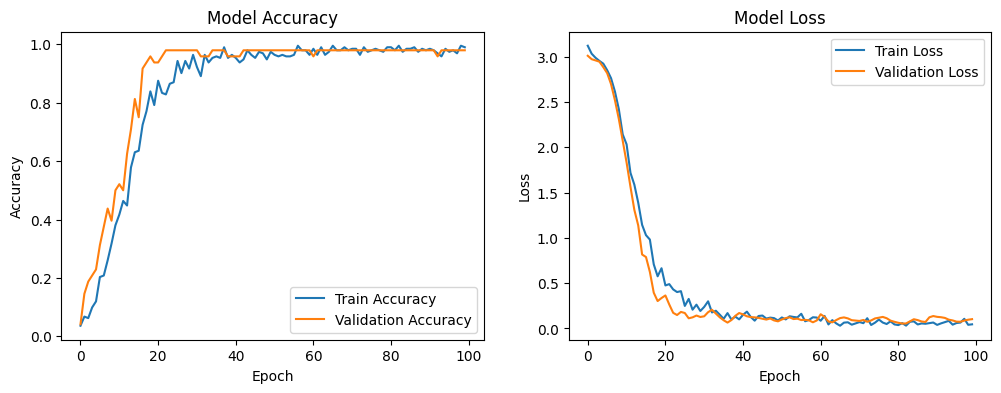

In [ ]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# Evaluate model performance on the test set
test_loss, test_accuracy = model.evaluate(testX, testY, verbose=2)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Predict classes for test data
predictions = model.predict(testX)
predicted_classes = np.argmax(predictions, axis=1)  # Convert one-hot encoding to class indices
true_classes = np.argmax(testY, axis=1)

# Print the first few predicted and true classes
print("Predicted classes:", predicted_classes[:10])
print("True classes:", true_classes[:10])



5/5 - 1s - 127ms/step - accuracy: 0.9563 - loss: 0.3022
Test Loss: 0.3022
Test Accuracy: 95.63%
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step
Predicted classes: [0 0 0 0 0 0 0 0 1 1]
True classes: [0 0 0 0 0 0 0 0 1 1]


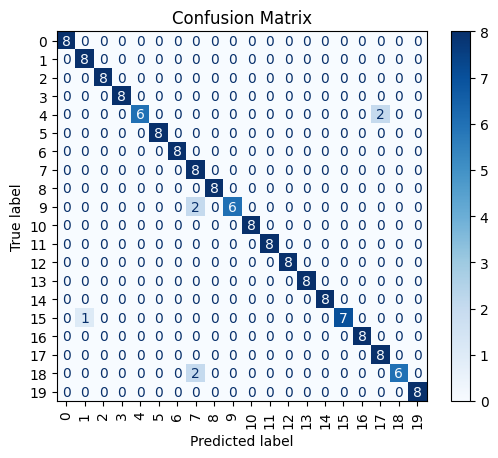

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=range(num_classes))
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Generate a classification report
class_report = classification_report(true_classes, predicted_classes, target_names=[f"Class {i}" for i in range(num_classes)])
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00         8
     Class 1       0.89      1.00      0.94         8
     Class 2       1.00      1.00      1.00         8
     Class 3       1.00      1.00      1.00         8
     Class 4       1.00      0.75      0.86         8
     Class 5       1.00      1.00      1.00         8
     Class 6       1.00      1.00      1.00         8
     Class 7       0.67      1.00      0.80         8
     Class 8       1.00      1.00      1.00         8
     Class 9       1.00      0.75      0.86         8
    Class 10       1.00      1.00      1.00         8
    Class 11       1.00      1.00      1.00         8
    Class 12       1.00      1.00      1.00         8
    Class 13       1.00      1.00      1.00         8
    Class 14       1.00      1.00      1.00         8
    Class 15       1.00      0.88      0.93         8
    Class 16       1.00      1.00      1.00         8
   

In [ ]:
# Accuracy per class
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
for i, acc in enumerate(class_accuracy):
    print(f"Accuracy for Class {i}: {acc * 100:.2f}%")

Accuracy for Class 0: 100.00%
Accuracy for Class 1: 100.00%
Accuracy for Class 2: 100.00%
Accuracy for Class 3: 100.00%
Accuracy for Class 4: 75.00%
Accuracy for Class 5: 100.00%
Accuracy for Class 6: 100.00%
Accuracy for Class 7: 100.00%
Accuracy for Class 8: 100.00%
Accuracy for Class 9: 75.00%
Accuracy for Class 10: 100.00%
Accuracy for Class 11: 100.00%
Accuracy for Class 12: 100.00%
Accuracy for Class 13: 100.00%
Accuracy for Class 14: 100.00%
Accuracy for Class 15: 87.50%
Accuracy for Class 16: 100.00%
Accuracy for Class 17: 100.00%
Accuracy for Class 18: 75.00%
Accuracy for Class 19: 100.00%


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.0573 - loss: 3.0029 - val_accuracy: 0.0208 - val_loss: 3.1164
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.0365 - loss: 3.1678 - val_accuracy: 0.0208 - val_loss: 3.0153
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.0417 - loss: 3.0222 - val_accuracy: 0.0208 - val_loss: 2.9974
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.0677 - loss: 2.9927 - val_accuracy: 0.1250 - val_loss: 2.9924
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.0625 - loss: 2.9805 - val_accuracy: 0.0417 - val_loss: 2.9929
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.1042 - loss: 2.9814 - val_accuracy: 0.1042 - val_loss: 2.9945
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.0885 - loss: 2.9733 - val_accuracy: 0.1042 - val_loss: 2.9967
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.0677 - loss: 2.9623 - val_accuracy: 0.1042 - val_loss: 2.995

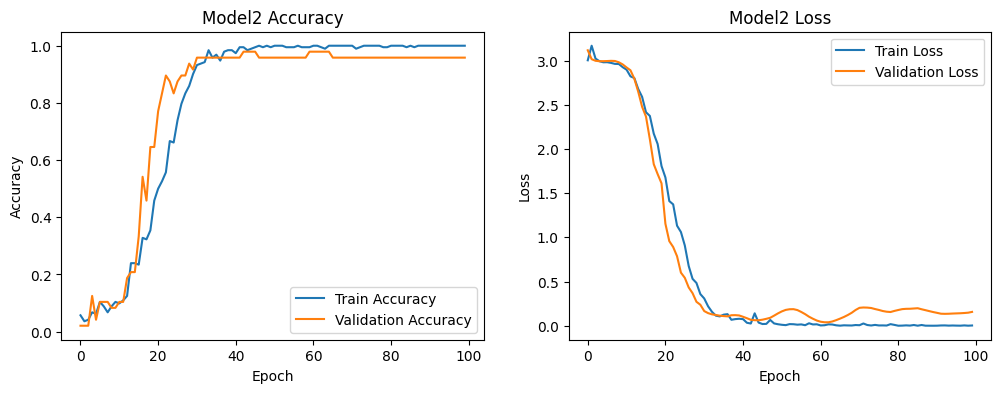

5/5 - 1s - 236ms/step - accuracy: 0.9563 - loss: 0.3022
Test Loss: 0.3022
Test Accuracy: 95.63%
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 487ms/step
Predicted classes: [0 0 0 0 0 0 0 0 1 1]
True classes: [0 0 0 0 0 0 0 0 1 1]


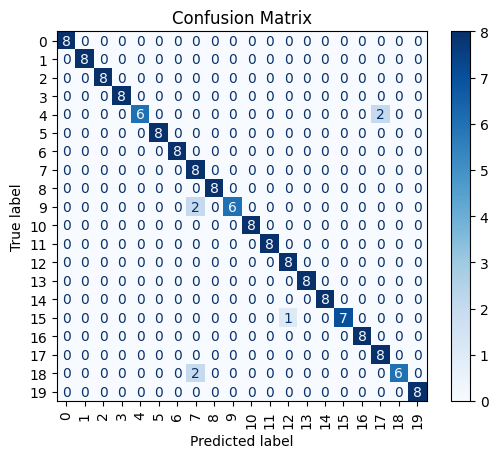

Classification Report:
               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00         8
     Class 1       1.00      1.00      1.00         8
     Class 2       1.00      1.00      1.00         8
     Class 3       1.00      1.00      1.00         8
     Class 4       1.00      0.75      0.86         8
     Class 5       1.00      1.00      1.00         8
     Class 6       1.00      1.00      1.00         8
     Class 7       0.67      1.00      0.80         8
     Class 8       1.00      1.00      1.00         8
     Class 9       1.00      0.75      0.86         8
    Class 10       1.00      1.00      1.00         8
    Class 11       1.00      1.00      1.00         8
    Class 12       0.89      1.00      0.94         8
    Class 13       1.00      1.00      1.00         8
    Class 14       1.00      1.00      1.00         8
    Class 15       1.00      0.88      0.93         8
    Class 16       1.00      1.00      1.00         8
   

In [ ]:
#alternative CNN

cnn_model2= Sequential([
    Conv2D(filters=36, kernel_size=7, activation='relu', input_shape= im_shape),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=54, kernel_size=5, activation='relu', input_shape= im_shape),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(2024, activation='relu'),
     Dropout(0.5),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(20, activation='softmax')
])

cnn_model2.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Train the model
history = cnn_model2.fit(
    trainX, trainY,
    validation_data=(valX, valY),
    epochs=100,
    batch_size=512
)

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model2 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model2 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Evaluate model performance on the test set
test2_loss, test2_accuracy = model.evaluate(testX, testY, verbose=2)
print(f"Test Loss: {test2_loss:.4f}")
print(f"Test Accuracy: {test2_accuracy * 100:.2f}%")

# Predict classes for test data
predictions = cnn_model2.predict(testX)
predicted_classes = np.argmax(predictions, axis=1)  # Convert one-hot encoding to class indices
true_classes = np.argmax(testY, axis=1)

# Print the first few predicted and true classes
print("Predicted classes:", predicted_classes[:10])
print("True classes:", true_classes[:10])

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=range(num_classes))
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

# Generate a classification report
class_report = classification_report(true_classes, predicted_classes, target_names=[f"Class {i}" for i in range(num_classes)])
print("Classification Report:\n", class_report)